In [1]:

from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_groq import ChatGroq
from dotenv import load_dotenv


In [2]:
load_dotenv()

True

In [3]:

class ParentState(TypedDict):

    question: str
    answer_eng: str
    answer_hin: str
    

In [4]:
subgraph_llm = ChatGroq(model = "llama-3.1-8b-instant")
parent_llm = ChatGroq(model = "llama-3.1-8b-instant")

In [5]:

def translate_text(state: ParentState):

    prompt = f"""
Translate the following text to Hindi.
Keep it natural and clear. Do not add extra content.

Text:
{state["answer_eng"]}
""".strip()
    
    translated_text = subgraph_llm.invoke(prompt).content

    return {'answer_hin': translated_text}

In [6]:

subgraph_builder = StateGraph(ParentState)

subgraph_builder.add_node('translate_text', translate_text)

subgraph_builder.add_edge(START, 'translate_text')
subgraph_builder.add_edge('translate_text', END)

subgraph = subgraph_builder.compile()

In [7]:
def generate_answer(state: ParentState):

    answer = parent_llm.invoke(f"You are a helpful assistant. Answer clearly.\n\nQuestion: {state['question']}").content
    return {'answer_eng': answer}

In [8]:

parent_builder = StateGraph(ParentState)

parent_builder.add_node("answer", generate_answer)
parent_builder.add_node("translate", subgraph)

parent_builder.add_edge(START, 'answer')
parent_builder.add_edge('answer', 'translate')
parent_builder.add_edge('translate', END)

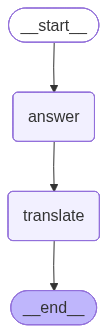

In [9]:

graph = parent_builder.compile()

graph

In [10]:

graph.invoke({'question': 'What is quantum physics'})

{'question': 'What is quantum physics',
 'answer_eng': 'Quantum physics, also known as quantum mechanics, is a branch of physics that studies the behavior of matter and energy at an atomic and subatomic level. It describes the physical phenomena that occur at the smallest scales, where the classical laws of physics no longer apply.\n\nIn classical physics, the behavior of objects is predictable and deterministic, meaning that if you know the initial conditions of a system, you can accurately predict its future behavior. However, at the quantum level, the behavior of particles such as electrons, photons, and atoms is fundamentally random and probabilistic. This means that even if you know the initial conditions of a system, you can only predict the probability of different possible outcomes.\n\nSome key principles of quantum physics include:\n\n1. **Wave-particle duality**: Quantum objects, such as electrons and photons, can exhibit both wave-like and particle-like behavior depending on